# Transformer model for predicting modalities in scRNA-seq

**Authors**<br>Vedu Mallela: Georgia Tech University, vedu.mallela@gmail.com<br>Simon Lee: UC Santa Cruz, siaulee@ucsc.edu

# Goal of the code

**TODO: explain algorithm**

# Libraries 

Import all files and modules for this competition<br>
*below will provide documentation of the following libraries*<br>
<br>
**scanpy** (**s**ingle **c**ell **an**alysis in **Py**thon) - https://scanpy.readthedocs.io/en/stable/ <br>
**anndata** (**ann**otated **data**) - https://anndata.readthedocs.io/en/latest/ <br>
**matplotlib** - https://matplotlib.org/ <br>
**numpy** - https://numpy.org/doc/stable/ <br>
**pandas** - https://pandas.pydata.org/ <br>
**logging** - https://docs.python.org/3/howto/logging.html <br>
**sklearn** - https://scikit-learn.org/stable/ <br>
<br>
*code begins here*

In [10]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import logging

import torch

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# LOAD DATA

In [12]:
path = '../../../../tmp/public/multiome/'
outpath ='../out/'
adata_gex = ad.read_h5ad(path + "multiome_gex_processed_training.h5ad")
adata_atac = ad.read_h5ad(path + "multiome_atac_processed_training.h5ad")

After successfully loading in the data, we can try to begin plotting the batch for the **Assay for Transposase-Accessible Chromatin using sequencing** (ATAC-seq) and **Gene Expression** (GEX) data on the umap interface. These umap projections will be saved to GEX.pdf and ATAC.pdf

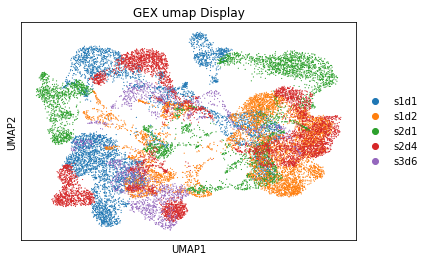

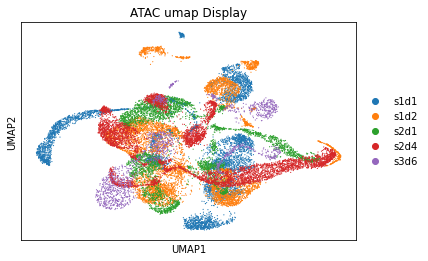

In [13]:
sc.tl.pca(adata_gex)
sc.pl.umap(adata_gex, color=['batch'],save='_GEX', title='GEX umap Display')
sc.tl.pca(adata_atac)
sc.pl.umap(adata_atac, color=['batch'], layer='counts', save='_ATAC', title='ATAC umap Display')

Next we are going to check out all the indivdual cell types occuring in both the ATAC and GEX data. This way we can see all the types of cells from this dataset provided.

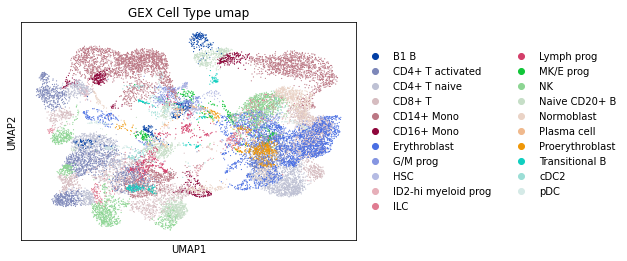

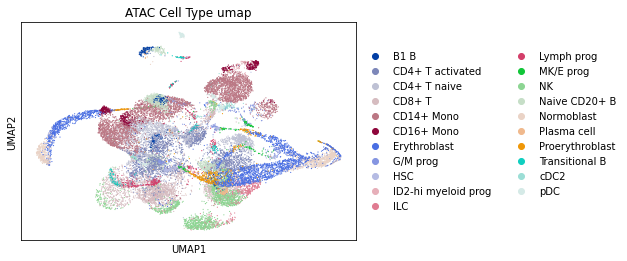

In [15]:
sc.tl.pca(adata_gex)
sc.pl.umap(adata_gex, color='cell_type',save='_GEX_ct', title='GEX Cell Type umap')
sc.tl.pca(adata_atac)
sc.pl.umap(adata_atac, color='cell_type',save='_ATAC_ct', title='ATAC Cell Type umap')

In [21]:
adata_gex.obs

,n_genes_by_counts,pct_counts_mt,n_counts,n_genes,size_factors,phase,cell_type,pseudotime_order_GEX,batch
TAGTTGTCACCCTCAC-1-s1d1,1022,1.061008,1508.0,1022,0.453484,S,Naive CD20+ B,NaN,s1d1
CTATGGCCATAACGGG-1-s1d1,1081,0.604230,1655.0,1081,0.455631,G2M,CD14+ Mono,NaN,s1d1
CCGCACACAGGTTAAA-1-s1d1,3304,0.650069,7230.0,3304,2.435348,G2M,CD8+ T,NaN,s1d1
TCATTTGGTAATGGAA-1-s1d1,793,0.812274,1108.0,793,0.347226,G2M,CD8+ T,NaN,s1d1
ACCACATAGGTGTCCA-1-s1d1,1219,1.674770,1851.0,1219,0.534205,G2M,CD16+ Mono,NaN,s1d1
...,...,...,...,...,...,...,...,...,...
TAGTAAGCAACTAGGG-8-s3d6,1313,0.000000,1937.0,1313,0.522115,S,HSC,0.098024,s3d6
TGGTCCTTCGGCTAGC-8-s3d6,2846,0.015901,6289.0,2846,1.737451,G2M,CD4+ T activated,NaN,s3d6
CGCTTGCGTTGTTGGA-8-s3d6,983,0.000000,1390.0,983,0.291723,G2M,pDC,NaN,s3d6
ACCCTCCCAGCCAGTT-8-s3d6,1351,0.000000,2190.0,1351,0.585303,G2M,CD8+ T,NaN,s3d6


In [22]:
adata_atac.obs

,nCount_peaks,atac_fragments,reads_in_peaks_frac,blacklist_fraction,nucleosome_signal,cell_type,pseudotime_order_ATAC,batch
TAGTTGTCACCCTCAC-1-s1d1,4031.0,5400,0.746481,0.003473,0.642468,Naive CD20+ B,NaN,s1d1
CTATGGCCATAACGGG-1-s1d1,8636.0,19266,0.448251,0.003126,1.220679,CD14+ Mono,NaN,s1d1
CCGCACACAGGTTAAA-1-s1d1,4674.0,6177,0.756678,0.001284,0.692573,CD8+ T,NaN,s1d1
TCATTTGGTAATGGAA-1-s1d1,2803.0,4019,0.697437,0.000714,0.633838,CD8+ T,NaN,s1d1
ACCACATAGGTGTCCA-1-s1d1,1790.0,2568,0.697040,0.003352,0.727660,CD16+ Mono,NaN,s1d1
...,...,...,...,...,...,...,...,...
TAGTAAGCAACTAGGG-8-s3d6,7239.0,10580,0.684216,0.000553,0.866142,HSC,0.23367,s3d6
TGGTCCTTCGGCTAGC-8-s3d6,16056.0,22771,0.705107,0.000810,0.964006,CD4+ T activated,NaN,s3d6
CGCTTGCGTTGTTGGA-8-s3d6,8388.0,14137,0.593337,0.000358,1.215227,pDC,NaN,s3d6
ACCCTCCCAGCCAGTT-8-s3d6,1001.0,1381,0.724837,0.000000,0.714286,CD8+ T,NaN,s3d6


We are now going to print out the number of observations and features of our GEX and ATAC-seq data. 

Few things to note before we proceed:



In [14]:
print(f"The GEX data has {adata_gex.n_obs} observations and {adata_gex.n_vars} features.")
print(f"The ATAC data has {adata_atac.n_obs} observations and {adata_atac.n_vars} features.")

The GEX data has 22463 observations and 13431 features.
The ATAC data has 22463 observations and 116490 features.


In [18]:
# filter out the data
# Convert anndata objects to dataframes and filter.  
# Genes that show up in < 1% cells are dropped.
# Atac seq data that shows up in < 1% cells are dropped 

gex_df = adata_gex.to_df()
atac_df = adata_atac.to_df()

mask = gex_df>0
total_cells = gex_df.shape[0]
maskdf = mask.sum(axis=0)/total_cells*100 <=1

gex_feature_drop  = list(maskdf.loc[maskdf==True].index.values)

mask = atac_df>0
maskdf = mask.sum(axis=0)/total_cells <=0.01

atac_feature_drop  = list(maskdf.loc[maskdf==True].index.values)

gex_ = gex_df.drop(columns=gex_feature_drop)
atac_ = atac_df.drop(columns=atac_feature_drop)

print('Filtered data set')
print('GEX data: Total cells=' + str(gex_.shape[0]) + ', Number features=' + str(gex_.shape[1]))
print('ATAC data: Total cells=' + str(atac_.shape[0]) + ', Number Features=' + str(atac_.shape[1]))

Filtered data set
GEX data: Total cells=22463, Number features=12160
ATAC data: Total cells=22463, Number Features=53020


In [19]:
gex_

,AL627309.5,LINC01409,LINC01128,NOC2L,ISG15,C1orf159,SDF4,B3GALT6,UBE2J2,ACAP3,...,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AL592183.1
TAGTTGTCACCCTCAC-1-s1d1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,4.410295,0.000000,4.410295,0.000000,0.000000,4.410295,0.0
CTATGGCCATAACGGG-1-s1d1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.194758,0.0,...,0.000000,0.000000,2.194758,0.000000,0.000000,0.000000,0.000000,0.000000,13.168547,0.0
CCGCACACAGGTTAAA-1-s1d1,0.410619,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.410619,0.821238,3.284951,0.410619,0.410619,0.821238,1.231857,0.410619,3.284951,0.0
TCATTTGGTAATGGAA-1-s1d1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,2.879966,11.519863,0.000000,0.000000,0.000000,5.759931,0.000000,0.000000,0.0
ACCACATAGGTGTCCA-1-s1d1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,3.743880,13.103581,1.871940,0.000000,3.743880,1.871940,0.000000,9.359701,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAGTAAGCAACTAGGG-8-s3d6,0.000000,0.0,0.0,0.0,1.915288,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
TGGTCCTTCGGCTAGC-8-s3d6,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CGCTTGCGTTGTTGGA-8-s3d6,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.427911,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
ACCCTCCCAGCCAGTT-8-s3d6,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [20]:
atac_

,chr1-181117-181803,chr1-629497-630394,chr1-633515-634474,chr1-778276-779191,chr1-816868-817761,chr1-827067-827948,chr1-842497-843414,chr1-869472-870377,chr1-904343-905196,chr1-906441-907357,...,GL000205.2-88673-89483,GL000205.2-140307-141166,GL000195.1-30407-31261,GL000195.1-32211-33062,GL000219.1-39933-40839,GL000219.1-42172-43054,GL000219.1-44703-45584,GL000219.1-45726-46450,GL000219.1-99257-100160,KI270713.1-21434-22336
TAGTTGTCACCCTCAC-1-s1d1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
CTATGGCCATAACGGG-1-s1d1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCGCACACAGGTTAAA-1-s1d1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCATTTGGTAATGGAA-1-s1d1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACCACATAGGTGTCCA-1-s1d1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAGTAAGCAACTAGGG-8-s3d6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TGGTCCTTCGGCTAGC-8-s3d6,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
CGCTTGCGTTGTTGGA-8-s3d6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
ACCCTCCCAGCCAGTT-8-s3d6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
